In [1]:
import pandas as pd
import numpy as np

import sklearn
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit, cross_val_score, KFold, HalvingRandomSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold

import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import mutual_info_regression, f_regression, r_regression, RFECV, SequentialFeatureSelector, SelectFromModel
from datetime import datetime as dt
import scipy.stats as stats



In [2]:
df = pd.read_csv('./wine+quality/winequality-red.csv', sep=";")

# Columns to ignore:
col_ignore = []

# Categorical columns to perform one-hot encoding:
col_ohe =[]

# Output column name:
output_col = ['quality']

# Drop unimportant columns:
df = df.drop(labels=col_ignore, axis=1)
print(f'shape of input df after dropping unimportant cloumns: {df.shape}')

# one hot encoding
for ohe in col_ohe:
    df = pd.concat((df, pd.get_dummies(df[ohe])), axis=1)
    df = df.drop(labels=[ohe], axis=1)

print(f'shape of input df after ohe: {df.shape}')

# creating x,y data:
df_y = df[output_col]
df_x = df.drop(labels=output_col, axis=1)
print(df_x.keys())
print(df_y.keys())

input_dataset_x = df_x.to_numpy()
input_dataset_y = df_y.to_numpy()
print(f'Data set shape:\nx: {input_dataset_x.shape},   y: {input_dataset_y.shape}', )

shape of input df after dropping unimportant cloumns: (1599, 12)
shape of input df after ohe: (1599, 12)
Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')
Index(['quality'], dtype='object')
Data set shape:
x: (1599, 11),   y: (1599, 1)


In [6]:
print(r_regression(input_dataset_x, input_dataset_y[:, 0]))

[ 0.12405165 -0.39055778  0.22637251  0.01373164 -0.12890656 -0.05065606
 -0.18510029 -0.17491923 -0.05773139  0.25139708  0.47616632]


In [7]:
print(f_regression(input_dataset_x, input_dataset_y[:, 0]))

(array([2.49600375e+01, 2.87444450e+02, 8.62577262e+01, 3.01183699e-01,
       2.69856084e+01, 4.10850227e+00, 5.66578176e+01, 5.04052231e+01,
       5.34046221e+00, 1.07740433e+02, 4.68267011e+02]), array([6.49563501e-07, 2.05171481e-59, 4.99129525e-20, 5.83218013e-01,
       2.31338265e-07, 4.28339795e-02, 8.62170342e-14, 1.87495665e-12,
       2.09627787e-02, 1.80208845e-24, 2.83147697e-91]))


In [8]:
print(mutual_info_regression(input_dataset_x, input_dataset_y[:, 0]))

[0.05928606 0.11569521 0.08402691 0.03233554 0.07154887 0.03093351
 0.07012868 0.0920609  0.0136016  0.09594582 0.18057991]


## Feature selection using SelectFromModel¶

In [9]:
lg = LinearRegression().fit(input_dataset_x, input_dataset_y)
model = SelectFromModel(lg, prefit=True)

In [10]:
X_new = model.transform(input_dataset_x)
X_new.shape

(1599, 1)

## Recursive feature elimination

Optimal number of features: 11


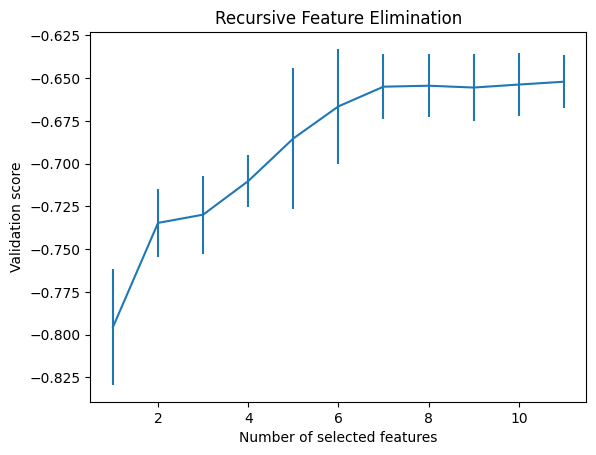

[1 1 1 1 1 1 1 1 1 1 1]


In [11]:
rfecv = RFECV(
    estimator=LinearRegression(),
    step=1,
    cv=KFold(5, shuffle=True, random_state=9),
    scoring="neg_root_mean_squared_error",
    min_features_to_select=1,
    n_jobs=-1,
)
rfecv.fit(input_dataset_x, input_dataset_y[:,:])

print(f"Optimal number of features: {rfecv.n_features_}")

n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of selected features")
plt.ylabel("Validation score")
plt.errorbar(
    range(1, n_scores + 1),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination")
plt.show()
print(rfecv.ranking_)

C:\Users\alisa\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\alisa\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\alisa\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Optimal number of features: 10


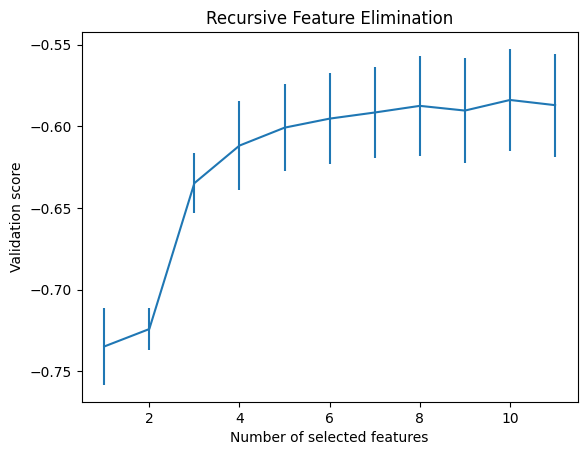

[1 1 1 1 1 2 1 1 1 1 1]


In [12]:
rfecv = RFECV(
    estimator=RandomForestRegressor(n_estimators=100, n_jobs=-1),
    step=1,
    cv=KFold(5, shuffle=True, random_state=9),
    scoring="neg_root_mean_squared_error",
    min_features_to_select=1,
    n_jobs=-1,
)
rfecv.fit(input_dataset_x, input_dataset_y[:,:])

print(f"Optimal number of features: {rfecv.n_features_}")

n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of selected features")
plt.ylabel("Validation score")
plt.errorbar(
    range(1, n_scores + 1),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination")
plt.show()
print(rfecv.ranking_)

C:\Users\alisa\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\alisa\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Optimal number of features: 11


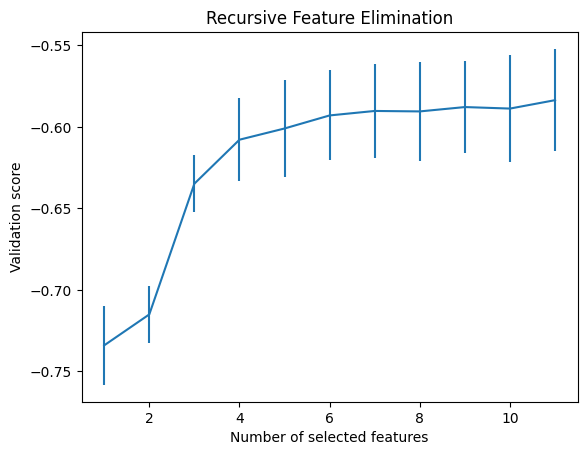

[1 1 1 1 1 1 1 1 1 1 1]


In [13]:
rfecv = RFECV(
    estimator=RandomForestRegressor(n_estimators=100, n_jobs=-1),
    step=1,
    cv=KFold(5, shuffle=True, random_state=9),
    scoring="neg_root_mean_squared_error",
    min_features_to_select=1,
    n_jobs=-1,
)
rfecv.fit(input_dataset_x, input_dataset_y[:,:])

print(f"Optimal number of features: {rfecv.n_features_}")

n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of selected features")
plt.ylabel("Validation score")
plt.errorbar(
    range(1, n_scores + 1),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination")
plt.show()
print(rfecv.ranking_)

C:\Users\alisa\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\alisa\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Optimal number of features: 11


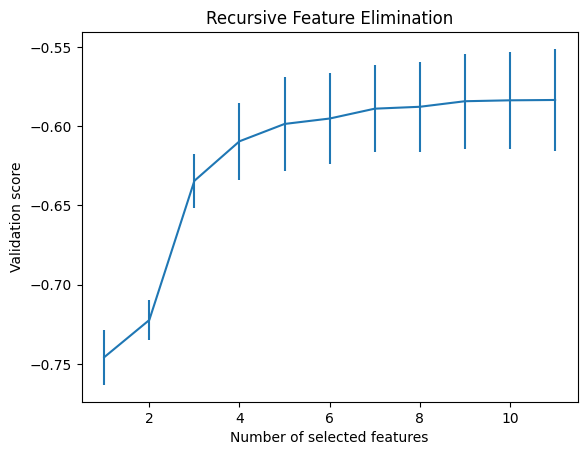

[1 1 1 1 1 1 1 1 1 1 1]


In [14]:
rfecv = RFECV(
    estimator=RandomForestRegressor(n_estimators=500, n_jobs=-1),
    step=1,
    cv=KFold(5, shuffle=True, random_state=9),
    scoring="neg_root_mean_squared_error",
    min_features_to_select=1,
    n_jobs=-1,
)
rfecv.fit(input_dataset_x, input_dataset_y[:,:])

print(f"Optimal number of features: {rfecv.n_features_}")

n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of selected features")
plt.ylabel("Validation score")
plt.errorbar(
    range(1, n_scores + 1),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination")
plt.show()
print(rfecv.ranking_)

C:\Users\alisa\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\alisa\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Optimal number of features: 11


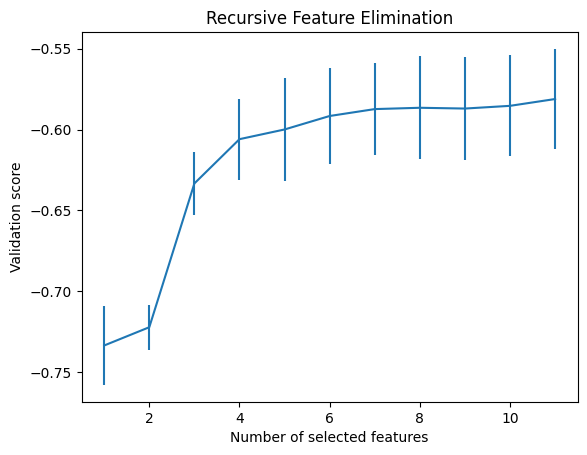

[1 1 1 1 1 1 1 1 1 1 1]


In [15]:
rfecv = RFECV(
    estimator=RandomForestRegressor(n_estimators=500, n_jobs=-1),
    step=1,
    cv=KFold(5, shuffle=True, random_state=9),
    scoring="neg_root_mean_squared_error",
    min_features_to_select=1,
    n_jobs=-1,
)
rfecv.fit(input_dataset_x, input_dataset_y[:,:])

print(f"Optimal number of features: {rfecv.n_features_}")

n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of selected features")
plt.ylabel("Validation score")
plt.errorbar(
    range(1, n_scores + 1),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination")
plt.show()
print(rfecv.ranking_)

In [56]:
input_dataset_x[:, [i for i in range(8) if rfecv.ranking_[i]==1]]

## SequentialFeatureSelector

In [16]:
sfs = SequentialFeatureSelector(LinearRegression(), n_features_to_select=6, direction='forward', n_jobs=-1)
sfs.fit(input_dataset_x, input_dataset_y)
sfs.get_support()

array([False,  True, False, False,  True,  True,  True, False,  True,
       False,  True])

In [17]:
sfs = SequentialFeatureSelector(RandomForestRegressor(), n_features_to_select=6, direction='forward', n_jobs=-1)
sfs.fit(input_dataset_x, input_dataset_y)
sfs.get_support()

array([ True,  True, False, False,  True, False,  True, False, False,
        True,  True])

In [118]:
sfs = SequentialFeatureSelector(RandomForestRegressor(), n_features_to_select=6, direction='forward', n_jobs=-1)
sfs.fit(input_dataset_x, input_dataset_y)
sfs.get_support()

array([ True,  True,  True,  True,  True,  True, False, False])

In [120]:
sfs = SequentialFeatureSelector(RandomForestRegressor(n_estimators=500), n_features_to_select=6, direction='forward', n_jobs=-1)
sfs.fit(input_dataset_x, input_dataset_y)
sfs.get_support()

array([ True,  True,  True,  True,  True, False,  True, False])

In [4]:
sfs = SequentialFeatureSelector(RandomForestRegressor(n_estimators=500, n_jobs=-1), n_features_to_select=6, direction='forward', n_jobs=-1)
sfs.fit(input_dataset_x, input_dataset_y)
sfs.get_support()

array([ True,  True,  True,  True,  True, False,  True, False])